In [14]:
#
# classifer notebook
#

# for Colab paths
# import sys
# sys.path.append('/content/')
#
#!nvidia-smi
#!nvidia-smi -q


import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, Compose
from LandmarkDataset import LandmarkDataset
from torch.utils.data.sampler import SubsetRandomSampler

torch.set_default_dtype(torch.float64)

#
# MODEL
#
# Should be 63 classes:
# Price B/S * 10                 -> 20
# QTY B/S * 10                   -> 20
# QTY B/S 10,20-100              -> 20
# Action Cancel, Market, Garbage ->  3
#                                -> 63
class NN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, num_classes)
        #self.fc2 = torch.nn.Linear(hidden_size, 48)
        #self.fc3 = torch.nn.Linear(48, num_classes)
        
        #44 with dropout .025
        #28 with .01
        self.dropout = torch.nn.Dropout(p=0.01)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        #out = self.dropout(out)
        
        out = self.fc2(out)
        #out = self.relu(out)
        #out = self.dropout(out)
        
        #out = self.fc3(out)
        
        return out

    
#
# PARAMS
#

batch_size = 12
hidden_size = 96
learning_rate = .01
num_epochs = 250


#
# INITIAL DATA
#

# for directory load each file
# generate mapping of file -> class -> idx
# if available copy data to gpu (model set below)
# typically need model + tensors (label and value) moved over. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transformations = Compose([
    Lambda(lambda x: torch.tensor(x.values).to(device))
])
target_transformations = Compose([
    Lambda(lambda x: torch.tensor(x).to(device))
])

dataset = LandmarkDataset("/home/jovyan/train/data",
                          "/home/jovyan/model",
                          transform=transformations)

num_classes = dataset.num_class
input_size = dataset.input_size() #2 * (21 * 3) + 12 + 1 + 10 #149 + 1 label = 150

training_indices, validation_indices = dataset.train_validation_indices(split_p = .2)
        
train_sampler = SubsetRandomSampler(training_indices)
valid_sampler = SubsetRandomSampler(validation_indices)
    
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)


#
# INIT MODELS, LOSS FN, GRAD
#

model = NN(input_size, hidden_size, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

#
# TRAIN
#

running_loss_epoch = 0
for epoch in range(num_epochs):
    for batch_idx, (labels, landmarks) in enumerate(train_dataloader):  

        # zero out accumulated gradients
        optimizer.zero_grad()
        
        # forward pass
        outputs = model(landmarks)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # NB: len(dataloader) is num of batches
        running_loss_epoch += loss.item()
        
        if ((epoch+1) % 10 == 0) and ((batch_idx+1) % len(train_dataloader) == 0):
            print ('Epoch [{}/{}], Loss per (random) batch: {:.4f}, Running Loss (per N epoch): {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item(), running_loss_epoch))
            running_loss_epoch = 0


Epoch [10/250], Loss per (random) batch: 1.2363, Running Loss (per N epoch): 19727.0497
Epoch [20/250], Loss per (random) batch: 1.5922, Running Loss (per N epoch): 13683.0703
Epoch [30/250], Loss per (random) batch: 0.7183, Running Loss (per N epoch): 12501.5439
Epoch [40/250], Loss per (random) batch: 0.5013, Running Loss (per N epoch): 11892.0230
Epoch [50/250], Loss per (random) batch: 1.2478, Running Loss (per N epoch): 11540.6802
Epoch [60/250], Loss per (random) batch: 1.7000, Running Loss (per N epoch): 11267.9581
Epoch [70/250], Loss per (random) batch: 1.2122, Running Loss (per N epoch): 10995.1081
Epoch [80/250], Loss per (random) batch: 0.9911, Running Loss (per N epoch): 10754.3127
Epoch [90/250], Loss per (random) batch: 0.7746, Running Loss (per N epoch): 10665.9416
Epoch [100/250], Loss per (random) batch: 0.6928, Running Loss (per N epoch): 10558.2585
Epoch [110/250], Loss per (random) batch: 0.4154, Running Loss (per N epoch): 10449.9354
Epoch [120/250], Loss per (ran

In [15]:
#
# EXPORT
#
# NB: LandmarkDataset.py updates meta.json with class index
#
dummy_input = torch.zeros(input_size)
#model.load_state_dict(torch.load('./model_overfit.pt'))
torch.onnx.export(model, dummy_input, 'onnx_model.onnx', export_params=True,
                  input_names = ['landmarks'], output_names = ['class'], verbose=True)

#import onnx
#onnx_model = onnx.load("./onnx_model.onnx")
#onnx.checker.check_model(onnx_model)


Exported graph: graph(%landmarks : Double(150, strides=[1], requires_grad=0, device=cpu),
      %fc1.bias : Double(96, strides=[1], requires_grad=1, device=cpu),
      %fc2.bias : Double(63, strides=[1], requires_grad=1, device=cpu),
      %onnx::MatMul_12 : Double(150, 96, strides=[1, 150], requires_grad=0, device=cpu),
      %onnx::MatMul_13 : Double(96, 63, strides=[1, 96], requires_grad=0, device=cpu)):
  %onnx::Add_6 : Double(96, strides=[1], device=cpu) = onnx::MatMul[onnx_name="MatMul_0"](%landmarks, %onnx::MatMul_12) # /opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %input : Double(96, strides=[1], requires_grad=1, device=cpu) = onnx::Add[onnx_name="Add_1"](%fc1.bias, %onnx::Add_6) # /opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py:114:0
  %onnx::MatMul_8 : Double(96, strides=[1], requires_grad=1, device=cpu) = onnx::Relu[onnx_name="Relu_2"](%input) # /opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1453:0
  %onnx::Add_

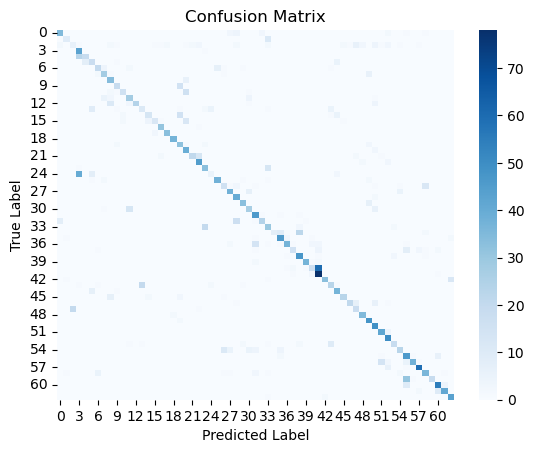

--------
Accuracy 1946/2880 : 0.6757
------------
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.71      0.74        49
           1       0.75      0.45      0.56        20
           2       0.23      0.12      0.16        48
           3       0.39      0.98      0.56        44
           4       0.70      0.45      0.55        42
           5       0.42      0.56      0.48        32
           6       0.69      0.56      0.62        36
           7       0.70      0.74      0.72        38
           8       0.57      0.85      0.68        40
           9       0.73      0.56      0.63        34
          10       0.80      0.44      0.57        36
          11       0.60      0.68      0.64        41
          12       1.00      0.56      0.72        43
          13       0.34      0.31      0.33        35
          14       0.68      0.36      0.47        36
          15       0.75      0.38      0.50        32
         

In [16]:
#
# EVAL
#
torch.set_printoptions(precision=4, sci_mode=False)
softmax = torch.nn.Softmax(dim=1)
accuracy = 0
count = 0

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_test = []
y_pred = []

with torch.no_grad():
    
    matches = {}
    counts = {}
    
    for batch_idx, (labels, landmarks) in enumerate(valid_dataloader):  
        out = model(landmarks)
        prob = softmax(out.data)     #setup for threshold or 'garbage' class
        _, klass = torch.max(out.data, 1)

        y_test = y_test + labels.tolist()
        y_pred = y_pred + klass.tolist()
        
        # aggregate accuracy
        accuracy += (klass == labels).sum().item()
        count += len(labels)
     
    
    cm = confusion_matrix(y_test, y_pred)    
    labels = dataset.class_map.keys()
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=False, cmap='Blues', fmt='g')
    plt.title(f"Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()        

print('--------')
print("Accuracy {}/{} : {:.4f}".format(accuracy, count, accuracy/count))
print("------------")
print("Classification Report")
print( classification_report(y_test, y_pred) )
print("------------")

# class vs percentage label match - track whether some gestures have bad data
acc = sorted([(int(k), v / counts.get(k, 1)) for k,v in matches.items()], key=lambda x:x[1])
for klass, match in acc:
    print(klass, " {:.4f}".format(match))



In [18]:
print("DONE")

DONE
